In [5]:
import data_visualization as dv
import metrics

import pandas as pd
from sklearn.cluster import KMeans

PATH_PFAS_LOCATIONS = '../Data/Unprocessed/EPA/PFAS_Locations.csv'
PATH_PWS_ZIP = '../Data/Unprocessed/EPA/UCMR5_ZIPCodes.txt'
PATH_PFAS = '../Data/Processed/PFAS.csv'
PATH_ZIPCODES = '../Data/Unprocessed/GeoNames/ZipCodes.txt'

PATH_PREDICTIONS = '../Data/predictions.csv'

In [17]:
columns = [
    "country_code", "postal_code", "place_name", "admin_name1", "admin_code1",
    "admin_name2", "admin_code2", "admin_name3", "admin_code3",
    "latitude", "longitude", "accuracy"
]
zipcodes = pd.read_csv(PATH_ZIPCODES, sep="\t", header=None, names=columns)[['postal_code', 'latitude', 'longitude']]

pfas_locations = pd.read_csv(PATH_PFAS_LOCATIONS, encoding="ISO-8859-1")['PWS ID']
pws_zipcodes = pd.read_csv(PATH_PWS_ZIP, sep="\t")

pfas_zipcodes = pd.merge(pfas_locations, pws_zipcodes, how='left', on='PWS ID')
pfas = pd.merge(pfas_zipcodes, zipcodes, how='left', left_on='ZIPCODE', right_on='postal_code')

pfas = pfas.drop_duplicates(subset='PWS ID').dropna()

index = pfas[pfas['latitude'] > 60].index
pfas = pfas.drop(index)

pfas.to_csv(PATH_PFAS, index=False)
print(len(pfas))

480


In [6]:
CLUSTERS = 7

pfas = pd.read_csv(PATH_PFAS)
results = pd.read_csv(PATH_PREDICTIONS)

kmeans = KMeans(n_clusters=CLUSTERS, random_state=0)

pfas['cluster'] = kmeans.fit_predict(pfas[['longitude', 'latitude']])
high_pfas = pfas[pfas['cluster'].isin([0, 1, 2, 6])]

In [7]:
cluster_stats = high_pfas.groupby('cluster').agg({
    'latitude': ['mean', 'std'],
    'longitude': ['mean', 'std'],
})
cluster_stats.columns = ["_".join(a) for a in cluster_stats.columns.to_flat_index()]

def is_within_cluster(lat, lon, cluster_stats, n_std=2):
    for _, stats in cluster_stats.iterrows():
        lat_within = abs(lat - stats['latitude_mean']) <= n_std * stats['latitude_std']
        lon_within = abs(lon - stats['longitude_mean']) <= n_std * stats['longitude_std']
        if lat_within and lon_within:
            return True
    return False

results['in_high_pfas_region'] = results.apply(
    lambda row: is_within_cluster(row['lat_true'], row['lon_true'], cluster_stats, n_std=2), axis=1
)

high_pfas_predictions = results[results['in_high_pfas_region']]

In [8]:
def in_bounds(results):
    lat_min, lat_max = 24.396308, 45
    lon_min, lon_max = -125.0, -66.93457
    outside_us = results[(results['lat_pred'] < lat_min) | (results['lat_pred'] > lat_max) |
                            (results['lon_pred'] < lon_min) | (results['lon_pred'] > lon_max)]
    inside_us = results[~results.index.isin(outside_us.index)]
    return inside_us, outside_us

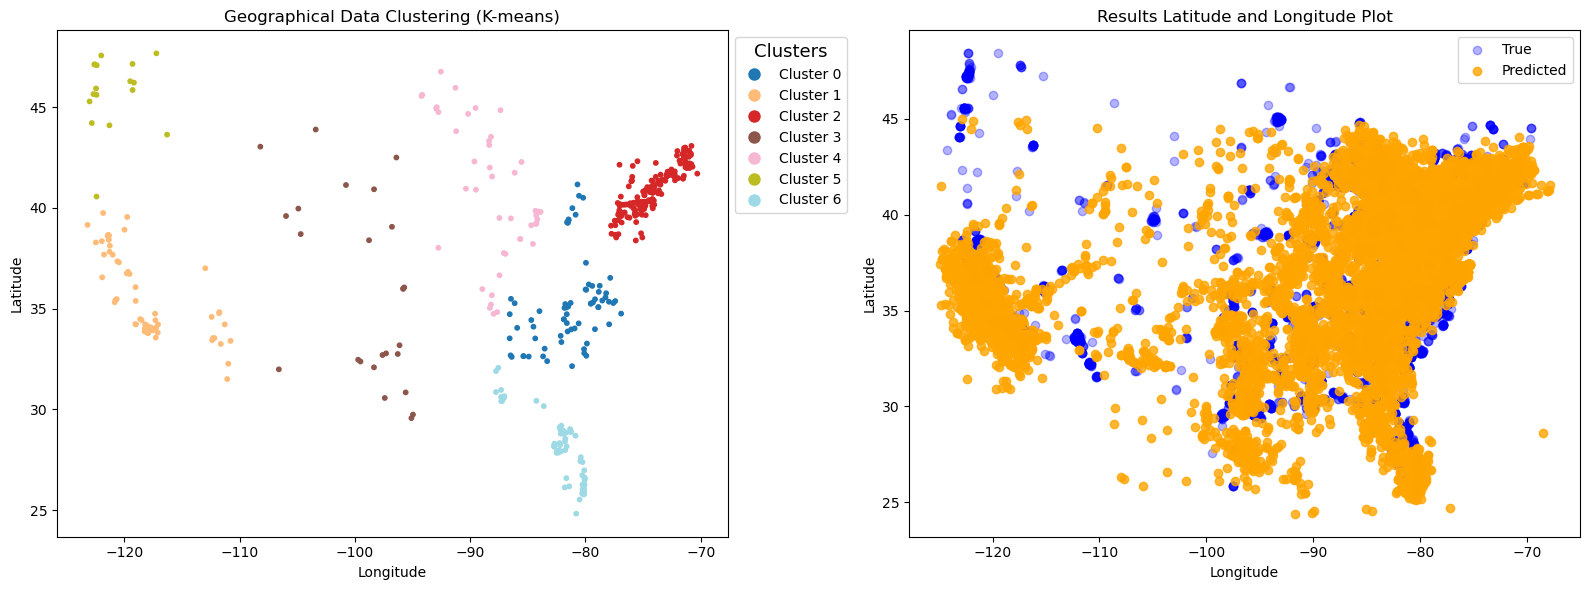

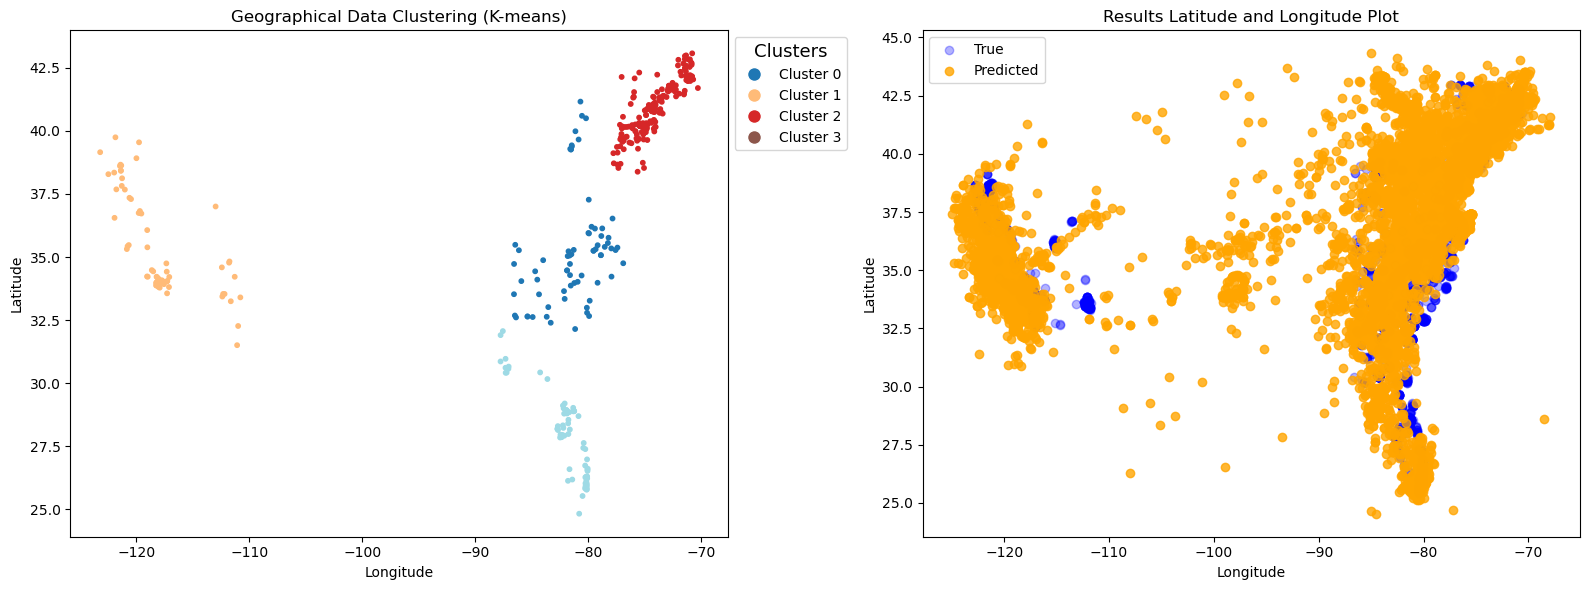

-------------------------------------
Results:
Mean SAE: 282.37
Median SAE: 125.36
Acc@161: 57.43
Precision: 0.04
Recall: 0.04
F1 Score: 0.04
-------------------------------------
Results:
Mean SAE: 234.10
Median SAE: 95.82
Acc@161: 63.02
Precision: 0.04
Recall: 0.04
F1 Score: 0.04
-------------------------------------
Mean SAE Difference: 48.269
Median SAE Difference: 29.541
Acc@161 Difference: -5.581
Precision Difference: -0.005
Recall Difference: -0.005
F1 Score Difference: -0.005
-------------------------------------
0.7658153241650295


In [ ]:
results_in, _ = in_bounds(results)
high_pfas_predictions_in, _ = in_bounds(high_pfas_predictions)

dv.plot_results(pfas, results_in)
dv.plot_results(high_pfas, high_pfas_predictions_in)
metrics_full = metrics.print_metrics(results)
metrics_high = metrics.print_metrics(high_pfas_predictions)

print("-------------------------------------")

for key, _ in metrics_full.items():
    results_difference = metrics_full[key] - metrics_high[key]
    print(f"{key} Difference: {results_difference:.3f}")

print("-------------------------------------")

print(len(high_pfas_predictions_in) / len(results_in))

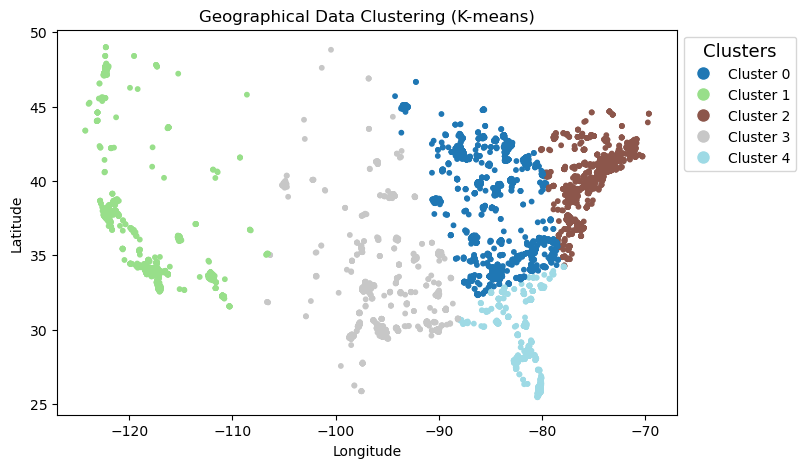

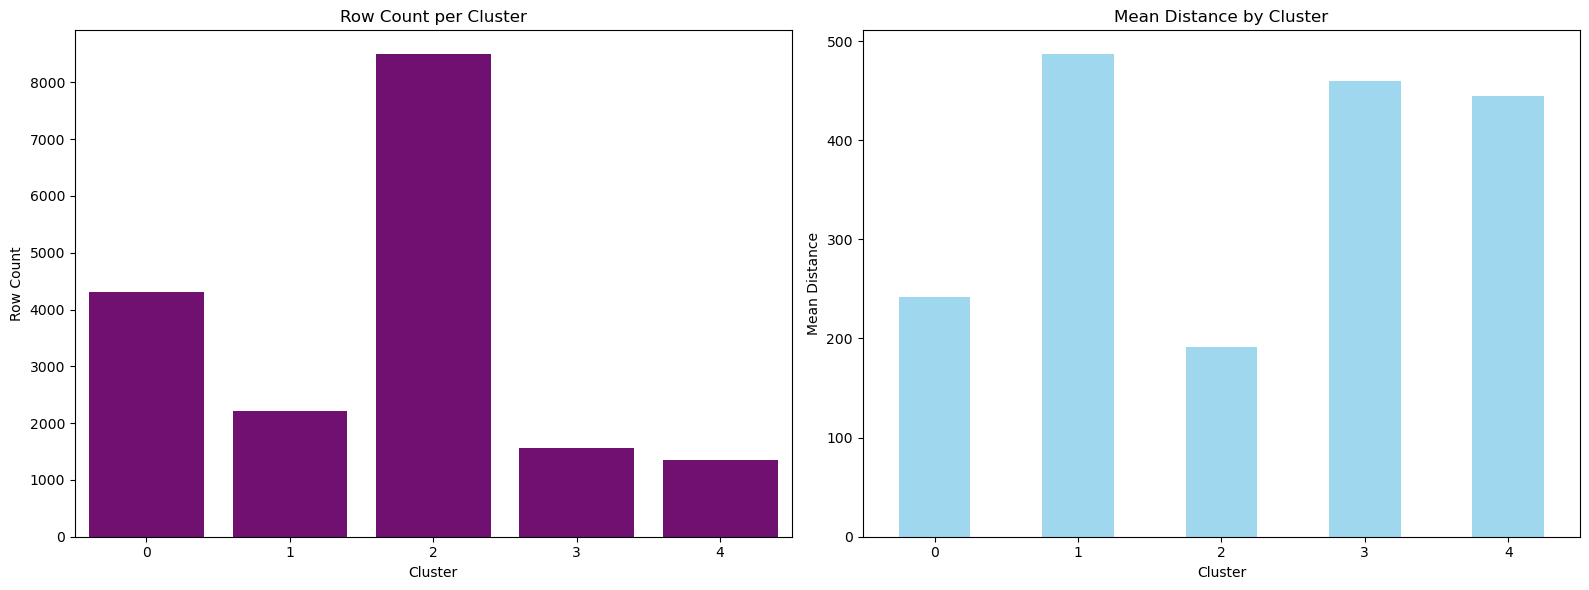

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

CLUSTERS = 5

results = pd.read_csv(PATH_PREDICTIONS)
results.rename(columns={'lon_true': 'longitude', 'lat_true': 'latitude'}, inplace=True)

kmeans = KMeans(n_clusters=CLUSTERS, random_state=1)
results['cluster'] = kmeans.fit_predict(results[['longitude', 'latitude']])

fig1, axes1 = plt.subplots(1, 1, figsize=(8, 5))
dv.show_clusters(axes1, results)


fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))

mean_distance = results.groupby('cluster')['distances'].mean()
mean_distance.plot(kind='bar', color='skyblue', alpha=0.8, ax=axes2[1])

axes2[1].set_title('Mean Distance by Cluster')
axes2[1].set_xlabel('Cluster')
axes2[1].set_ylabel('Mean Distance')
axes2[1].tick_params(axis='x', rotation=0)

dv.show_count(axes2[0], results.groupby('cluster').size().reset_index(name='cluster_count'))

plt.tight_layout()
plt.show()

In [4]:
results_0 = pd.read_csv('../Data/predictions.csv')
results_100 = pd.read_csv('../Data/predictions-100.csv')

metrics_0 = metrics.print_metrics(results_0)
metrics_100 = metrics.print_metrics(results_100)

print("-------------------------------------")

for key, _ in metrics_0.items():
    results_difference = metrics_100[key] - metrics_0[key]
    print(f"{key} Difference: {results_difference:.3f}")

-------------------------------------
Results:
Mean SAE: 282.37
Median SAE: 125.36
Acc@161: 57.43
Precision: 0.04
Recall: 0.04
F1 Score: 0.04
-------------------------------------
Results:
Mean SAE: 322.12
Median SAE: 136.48
Acc@161: 55.13
Precision: 0.03
Recall: 0.03
F1 Score: 0.03
-------------------------------------
Mean SAE Difference: 39.751
Median SAE Difference: 11.114
Acc@161 Difference: -2.299
Precision Difference: -0.002
Recall Difference: -0.002
F1 Score Difference: -0.002


In [ ]:
from nltk.corpus import stopwords

from collections import Counter
import re

high_error_predictions = results[results['cluster'].isin([1, 3, 4])]
high_error_predictions = high_error_predictions.sort_values(by='distances', ascending=False).head(100)

top_errors_text = high_error_predictions[['text', 'distances', 'latitude', 'longitude', 'lat_pred', 'lon_pred', 'cluster']]
print(top_errors_text.head(10))

stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    # Tokenize the text
    words = re.findall(r'\w+', text.lower())
    # Remove stopwords
    return [word for word in words if word not in stop_words]

# Tokenize and clean the text data
cleaned_words = []
for text in top_errors_text['text'].astype(str):
    cleaned_words.extend(remove_stopwords(text))

word_counts = Counter(cleaned_words)

# Display the most common words in the text of high-error predictions
print(word_counts.most_common(10))

                                                    text    distances  \
9145                                                 NaN  3995.262467   
1751   i think were going to name my debut solo album...  3887.415109   
5104   just got to my sons coed vollyball gamethis fo...  3886.114663   
14298  ouch its not my fault im stationed in shitty s...  3872.835473   
4271   i mean i jus dont like florida nolie its live ...  3858.827087   
5686   rt i havent clubbed in forever now i think i w...  3807.914036   
10918                        your appreciated in my book  3799.290475   
8588                                    wats wrong wit u  3798.383245   
11385  rt rt amitheonlyone tht thinks looks like a mc...  3791.549905   
9748                 rt class then bowling tonight im in  3791.486156   

        latitude   longitude   lat_pred   lon_pred  cluster  
9145   37.730418 -122.427644  40.288240  -75.76334        1  
1751   38.475521 -121.443418  40.288240  -75.76334        1  
5104   38.